#  Exploratory Data Analysis — Pasture Biomass Estimation

This notebook performs an **Exploratory Data Analysis (EDA)** for the *Pasture Biomass Prediction* competition on Kaggle.  
The main goal is to understand the structure, quality, and relationships within the training data before moving on to model development and pipeline design.

---

## Objectives

- Inspect the dataset structure, types, and completeness  
- Explore the distribution of the target variables and their correlations  
- Analyze how **biomass** relates to field measurements such as **NDVI** and **average height**  
- Evaluate the impact of categorical features like **State** and **Species composition**  
- Visually inspect sample images to understand potential variability (color, texture, seasonality)  
- Identify issues that may affect model training — such as outliers, missing values, or leakage risks  

---

## Dataset Overview

Each training record corresponds to a **single pasture image** annotated with multiple biomass measurements.  
For each image (`sample_id`), there are five target components to predict:

| Target name | Meaning | Weight in global R² |
|:-------------|:---------|:-------------------|
| `Dry_Green_g` | Biomass of green dry material | 0.1 |
| `Dry_Dead_g` | Biomass of dead dry material | 0.1 |
| `Dry_Clover_g` | Biomass of dry clover | 0.1 |
| `GDM_g` | Green dry matter | 0.2 |
| `Dry_Total_g` | Total dry biomass | 0.5 |

The challenge involves predicting all five targets for each test image, combining **visual** (image-based) and **tabular** (sensor and metadata) features.

---

Next, we begin with data loading and initial inspection.


In [1]:
# ============================================================
# 🧩 01_EDA.ipynb — Block 1: Setup & Data Loading
# ============================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# General display setup
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 1000)
sns.set(style="whitegrid", context="notebook")

# ============================================================
# Paths — adjust if running from a different directory
# ============================================================

BASE_DIR = "."  # project root

TRAIN_CSV = os.path.join(BASE_DIR, "train.csv")
TEST_CSV = os.path.join(BASE_DIR, "test.csv")
SAMPLE_SUB = os.path.join(BASE_DIR, "sample_submission.csv")

# ============================================================
# Read data
# ============================================================
train = pd.read_csv(TRAIN_CSV)
test = pd.read_csv(TEST_CSV)
sample_sub = pd.read_csv(SAMPLE_SUB)

print(f"✅ Train shape: {train.shape}")
print(f"✅ Test shape:  {test.shape}")
print(f"✅ Sample submission shape: {sample_sub.shape}")

# Quick peek
train.head()

✅ Train shape: (1785, 9)
✅ Test shape:  (5, 3)
✅ Sample submission shape: (5, 2)


,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750


In [2]:
# Basi inspection & data quality
print("Column overview:\n")
display(train.dtypes)

print("\nBasic info:")
train.info()

print("\nUnique counts per column:")
display(train.nunique())

print("\nMissing values per column:")
display(train.isna().sum())

print("\nSample of target_name values:")
display(train["target_name"].value_counts())

# Sanity checks
print("\nChecking duplicate rows...")
dup_rows = train.duplicated().sum()
print(f"→ Duplicate rows: {dup_rows}")

print("\nChecking how many unique images (sample_id base):")
# The sample_id includes the target_name, so remove it
train["image_id"] = train["sample_id"].str.split("__").str[0]
n_images = train["image_id"].nunique()
n_rows_per_image = train.shape[0] / n_images
print(f"→ {n_images} unique images; ~{n_rows_per_image:.1f} rows per image (should be ≈5)")

# Quick preview of numeric columns
num_cols = ["Pre_GSHH_NDVI", "Height_Ave_cm", "target"]
display(train[num_cols].describe())

Column overview:



sample_id         object
image_path        object
Sampling_Date     object
State             object
Species           object
Pre_GSHH_NDVI    float64
Height_Ave_cm    float64
target_name       object
target           float64
dtype: object


Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_id      1785 non-null   object 
 1   image_path     1785 non-null   object 
 2   Sampling_Date  1785 non-null   object 
 3   State          1785 non-null   object 
 4   Species        1785 non-null   object 
 5   Pre_GSHH_NDVI  1785 non-null   float64
 6   Height_Ave_cm  1785 non-null   float64
 7   target_name    1785 non-null   object 
 8   target         1785 non-null   float64
dtypes: float64(3), object(6)
memory usage: 125.6+ KB

Unique counts per column:


sample_id        1785
image_path        357
Sampling_Date      28
State               4
Species            15
Pre_GSHH_NDVI      65
Height_Ave_cm      81
target_name         5
target           1328
dtype: int64


Missing values per column:


sample_id        0
image_path       0
Sampling_Date    0
State            0
Species          0
Pre_GSHH_NDVI    0
Height_Ave_cm    0
target_name      0
target           0
dtype: int64


Sample of target_name values:


Dry_Clover_g    357
Dry_Dead_g      357
Dry_Green_g     357
Dry_Total_g     357
GDM_g           357
Name: target_name, dtype: int64


Checking duplicate rows...
→ Duplicate rows: 0

Checking how many unique images (sample_id base):
→ 357 unique images; ~5.0 rows per image (should be ≈5)


,Pre_GSHH_NDVI,Height_Ave_cm,target
count,1785.000000,1785.000000,1785.000000
mean,0.657423,7.595985,24.782295
std,0.151972,10.273725,25.823738
min,0.160000,1.000000,0.000000
25%,0.560000,3.000000,4.818200
50%,0.690000,4.000000,18.200000
75%,0.770000,7.000000,35.940600
max,0.910000,70.000000,185.700000


,count,mean,std,min,25%,50%,75%,max
target_name,,,,,,,,
Dry_Clover_g,357.0,6.649692,12.117761,0.00,0.0000,1.4235,7.2429,71.7865
Dry_Dead_g,357.0,12.044548,12.402007,0.00,3.2000,7.9809,17.6378,83.8407
Dry_Green_g,357.0,26.624722,25.401232,0.00,8.8000,20.8000,35.0834,157.9836
Dry_Total_g,357.0,45.318097,27.984015,1.04,25.2715,40.3000,57.8800,185.7000
GDM_g,357.0,33.274414,24.935822,1.04,16.0261,27.1082,43.6757,157.9836


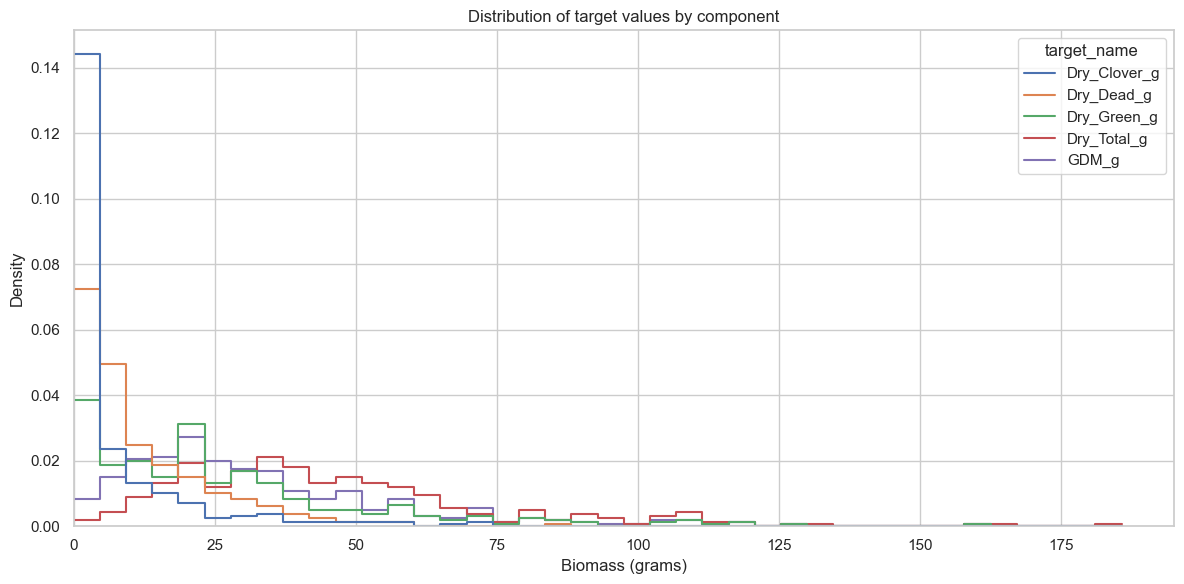

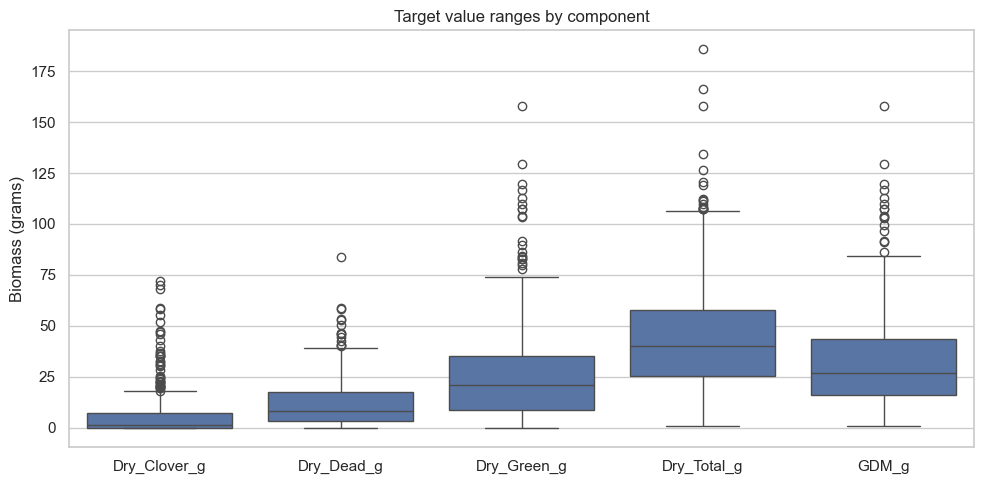

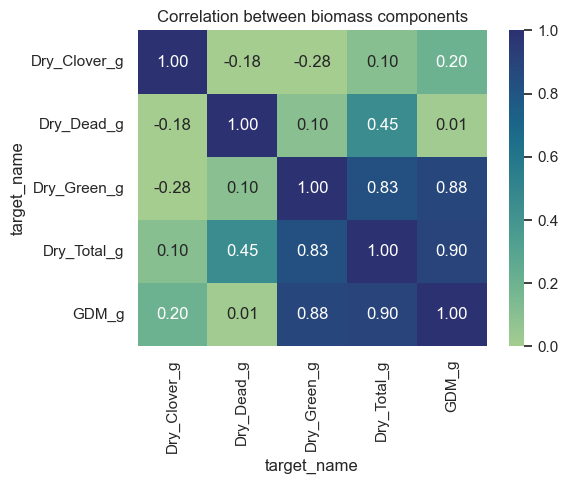

In [3]:
# ============================================================
# Target exploration

import matplotlib.ticker as mtick

# --- Summary statistics per target type
target_summary = (
    train.groupby("target_name")["target"]
    .describe()
    .sort_index()
)
display(target_summary)

# --- Histograms by target_name
plt.figure(figsize=(12, 6))
sns.histplot(
    data=train,
    x="target",
    hue="target_name",
    bins=40,
    element="step",
    fill=False,
    stat="density",
    common_norm=False,   # evita normalizar tudo junto
)
plt.title("Distribution of target values by component")
plt.xlabel("Biomass (grams)")
plt.ylabel("Density")
plt.xlim(0, None)
plt.tight_layout()
plt.show()

# --- Boxplots to visualize spread/outliers
plt.figure(figsize=(10, 5))
sns.boxplot(data=train, x="target_name", y="target")
plt.title("Target value ranges by component")
plt.ylabel("Biomass (grams)")
plt.xlabel("")
plt.tight_layout()
plt.show()

# --- Pivot for correlation matrix between targets per image
target_pivot = train.pivot_table(
    index="image_id",
    columns="target_name",
    values="target"
)
corr = target_pivot.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="crest", vmin=0, vmax=1)
plt.title("Correlation between biomass components")
plt.tight_layout()
plt.show()

# some conclusions to guide our future modeling process

- **Boxplots** → asymetric distributions; _Dry_Total_g_ dominates in magnitudes and long tails (up to ~180 g).
→ This might indicate that we will need to **normalize or log-transform** the target before training.
_Dry_Clover_g_ is the lower in magnitude and more concentrated; possibly the **hardest to predict** given the small signal.

- **Correlation** → interesting:

    _Dry_Total_g_ strongly correlates with _Dry_Green_g_ (0.83) and _GDM_g_ (0.90).

    _Dry_Clover_g_ and _Dry_Dead_g_ are almost independents (correlações ≤ 0.2).
    → This suggests a **multi-task model** partly sharing weights, where one backbone learns the general structure and separated heads refine each component.

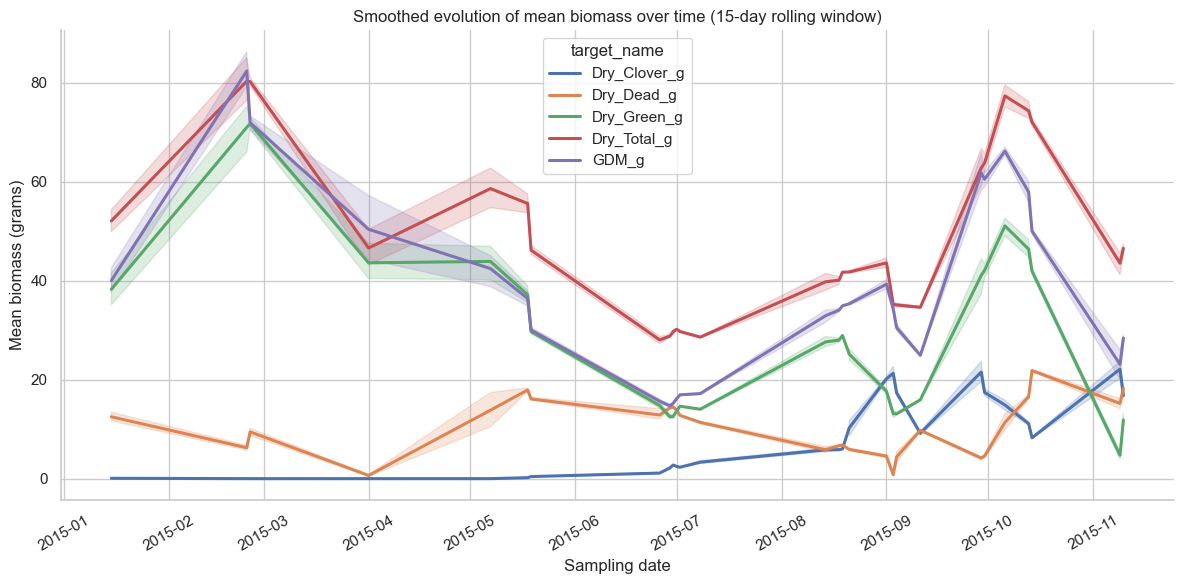

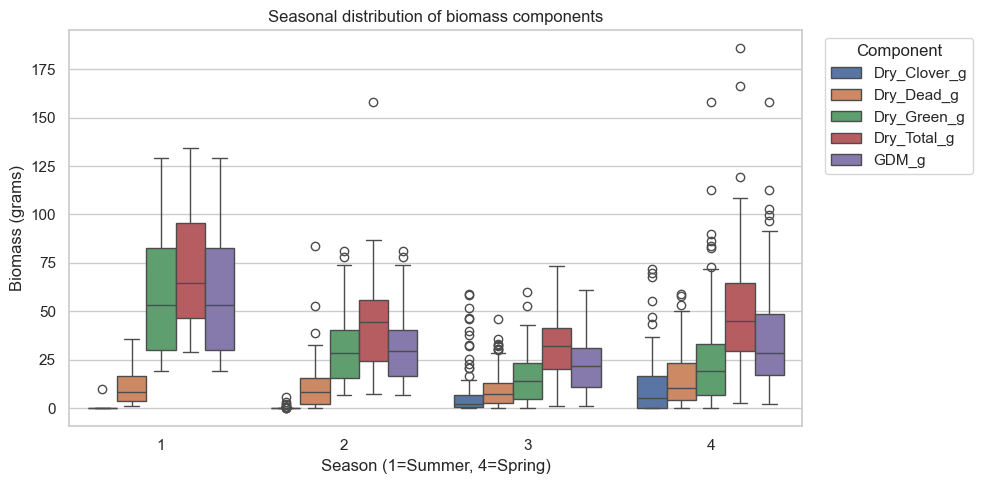

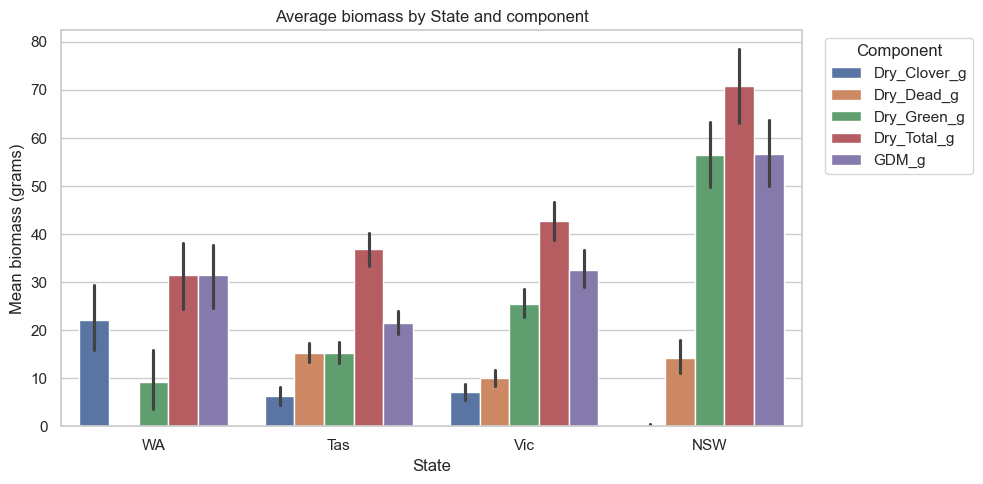

mean    std  count
State target_name                      
NSW   Dry_Clover_g   0.13   1.17     75
      Dry_Dead_g    14.20  15.63     75
      Dry_Green_g   56.56  31.23     75
      Dry_Total_g   70.90  35.58     75
      GDM_g         56.69  31.26     75
Tas   Dry_Clover_g   6.24  11.61    138
      Dry_Dead_g    15.23  12.43    138
      Dry_Green_g   15.33  13.11    138
      Dry_Total_g   36.80  20.70    138
      GDM_g         21.57  14.36    138

In [4]:
# ============================================================
# Temporal and spatial analysis: sesonality and geographic particularities

from matplotlib.dates import DateFormatter

# --- Parse Sampling_Date (YYYY/MM/DD)
train["Sampling_Date"] = pd.to_datetime(train["Sampling_Date"], errors="coerce")

# --- Derive temporal features
train["year"] = train["Sampling_Date"].dt.year
train["month"] = train["Sampling_Date"].dt.month
train["season"] = train["month"] % 12 // 3 + 1  # 1:summer, 2:autumn, 3:winter, 4:spring (roughly for southern hemi.)

# ============================================================
# Temporal evolution of biomass
# ============================================================

# Ordenar e aplicar média móvel por componente
df_smooth = (
    train.sort_values("Sampling_Date")
    .groupby("target_name")[["Sampling_Date", "target"]]
    .apply(lambda g: g.set_index("Sampling_Date").rolling("15D", min_periods=1).mean())
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_smooth,
    x="Sampling_Date",
    y="target",
    hue="target_name",
    linewidth=2.2,
)
plt.title("Smoothed evolution of mean biomass over time (15-day rolling window)")
plt.xlabel("Sampling date")
plt.ylabel("Mean biomass (grams)")
plt.xticks(rotation=30)
sns.despine()
plt.tight_layout()
plt.show()

# ============================================================
# Seasonality boxplots
# ============================================================
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=train,
    x="season",
    y="target",
    hue="target_name"
)
plt.title("Seasonal distribution of biomass components")
plt.xlabel("Season (1=Summer, 4=Spring)")
plt.ylabel("Biomass (grams)")
plt.legend(title="Component", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ============================================================
# Spatial differences (by Australian state)
# ============================================================

state_order = train.groupby("State")["target"].mean().sort_values().index

plt.figure(figsize=(10, 5))
sns.barplot(
    data=train,
    x="State",
    y="target",
    hue="target_name",
    order=state_order,
    estimator="mean",
)
plt.title("Average biomass by State and component")
plt.ylabel("Mean biomass (grams)")
plt.xlabel("State")
plt.legend(title="Component", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# --- quick numeric summary by State
state_summary = (
    train.groupby(["State", "target_name"])["target"]
    .agg(["mean", "std", "count"])
    .round(2)
)
display(state_summary.head(10))

# Interpretation — Temporal & Spatial patterns

**-- Temporal evolution**

- There are well-defined biomass peaks between february-march and, again, in october, which is consistent with the austral spring/summer (high vegetal produtivity).
- Between may and july, all components drop significantly, indicating dry winter or low photosynthesis.
- _Dry_Total_g, GDM_g and Dry_Green_g_ curves basically move in phase, reinforcing the high correlation (R ≈ 0.8–0.9).
- _Dry_Dead_g_ shows opposite behavior in the extremes (tends to grow when the green falls), which may be capturing the seniority of the vegetation.
- _Dry_Clover_g_ keeps low values and variability, which may be the most noisy target or more dependent of the dominant specit in the field.


**-- Seasonality**

- Boxplot shows clearly the higher biomass in the summer, with median values decreasing till winter.
- This confirms that including month or season as cyclic feature (sin/cos) will be important to the tabular model.
- The variability also grows on summer, which indicates climate condition diversity or difference between states.


**-- Spatial variability**

- NSW (New South Wales) shows the highest averages among all components, specially for _Dry_Total_g_ (~70 g).
- WA (Western Australia) and Tas (Tasmania) have much lower averages (~20–30 g).
- This geographic heterogeneity sugeests that "State" is a variable highly informative, which may be treated as a categorical embbeding or one-hot, since there is only 4 states.
- The dispersion indicates that even within a given state there is significant variation, possibly associated with species or microclimate.


# Practical conclusion for modeling

1. Use _month_ → code with sin/cos to capture annual periodicity.
2. Use _State_ as a relevant categorical variable.
3. Expect multimodal and non-linear behavior -> neural networks or grafient boosting may be better candidates than linear regression.
4. Possible imbalanced data — verify and reweighting or stratified sampling. Verifying below...

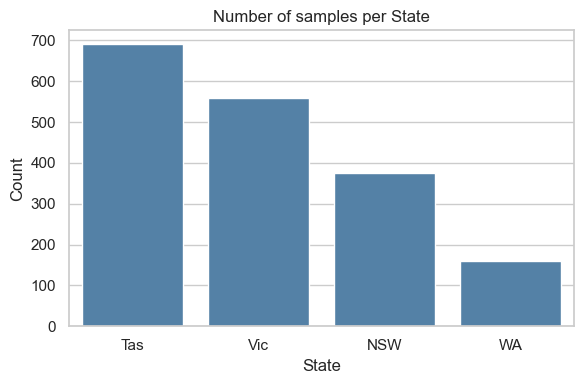

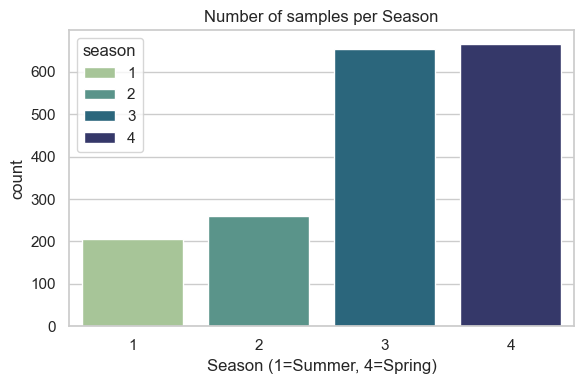

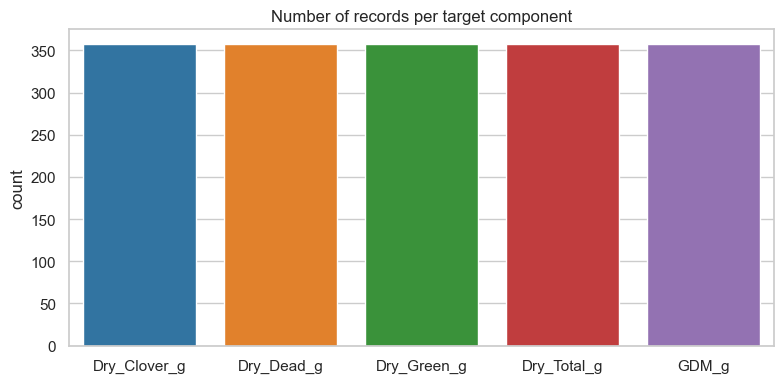

{'By State': {'Tas': 690, 'Vic': 560, 'NSW': 375, 'WA': 160},
 'By Season': {4: 665, 3: 655, 2: 260, 1: 205},
 'By Target': {'Dry_Clover_g': 357,
  'Dry_Dead_g': 357,
  'Dry_Green_g': 357,
  'Dry_Total_g': 357,
  'GDM_g': 357}}

In [5]:
# ============================================================
# Verify imbalanced
# ============================================================

# ------------------------------------------------------------
# Imbalance analysis
# ------------------------------------------------------------

# 1. Counts by State
state_counts = train["State"].value_counts().rename_axis("State").reset_index(name="count")
plt.figure(figsize=(6,4))
sns.barplot(data=state_counts, x="State", y="count", color="steelblue")
plt.title("Number of samples per State")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2. Counts by Season
plt.figure(figsize=(6,4))
sns.countplot(data=train, x="season", palette="crest", hue="season")
plt.title("Number of samples per Season")
plt.xlabel("Season (1=Summer, 4=Spring)")
plt.tight_layout()
plt.show()

# 3. Balance across target components
plt.figure(figsize=(8,4))
sns.countplot(data=train, x="target_name", palette="tab10", hue="target_name")
plt.title("Number of records per target component")
plt.xlabel("")
plt.tight_layout()
plt.show()

# Quick summary table
imbalance_summary = {
    "By State": state_counts.set_index("State")["count"].to_dict(),
    "By Season": train["season"].value_counts().to_dict(),
    "By Target": train["target_name"].value_counts().to_dict(),
}
imbalance_summary

--------------------
**YES, IMBALANCED!**
--------------------

,corr_NDVI,corr_Height
target_name,,
Dry_Clover_g,0.22,-0.16
Dry_Dead_g,-0.12,-0.05
Dry_Green_g,0.35,0.65
Dry_Total_g,0.36,0.50
GDM_g,0.47,0.58


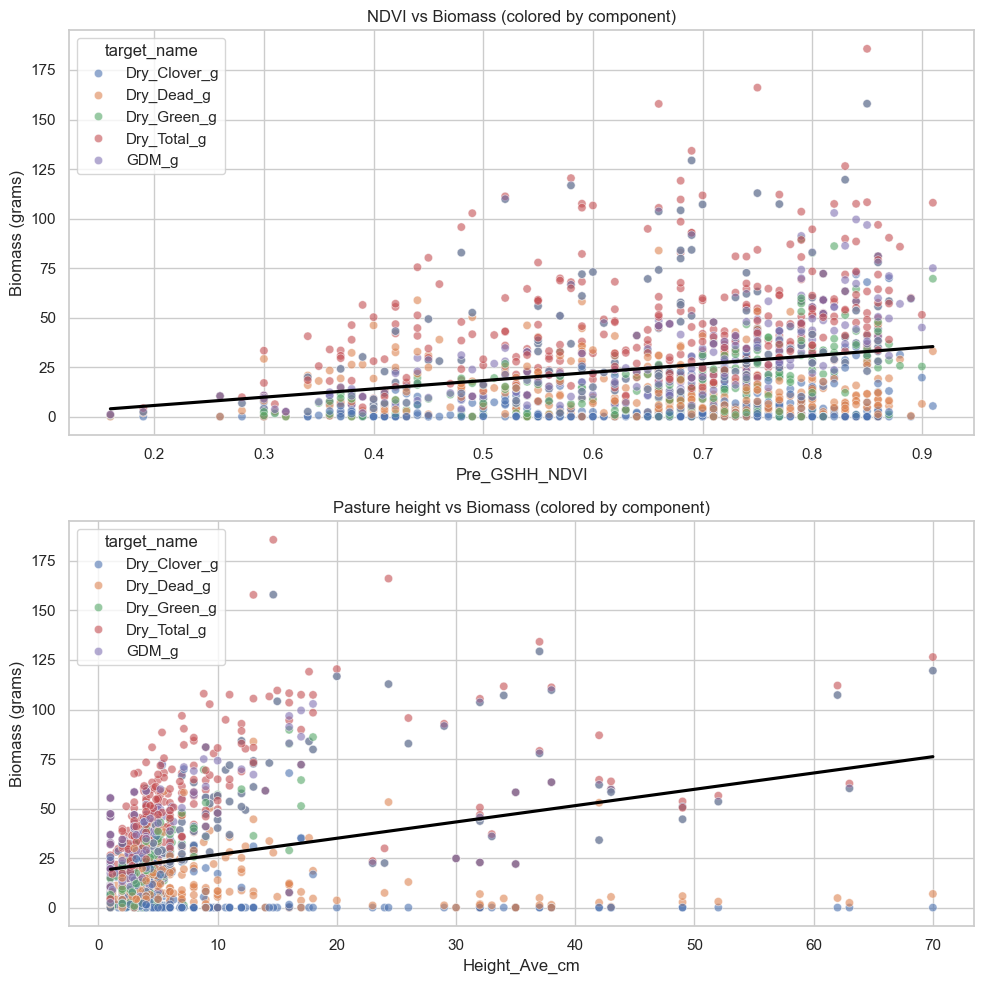

In [6]:
#=============================================
# Physic-statistical relations: NVDI & Height

from scipy.stats import pearsonr

# ------------------------------------------------------------
# Correlações simples
# ------------------------------------------------------------
num_feats = ["Pre_GSHH_NDVI", "Height_Ave_cm"]
corrs = (
    train.groupby("target_name")[num_feats + ["target"]]
    .apply(lambda g: pd.Series({
        "corr_NDVI": pearsonr(g["Pre_GSHH_NDVI"], g["target"])[0],
        "corr_Height": pearsonr(g["Height_Ave_cm"], g["target"])[0]
    }))
    .round(2)
)
display(corrs)

# ------------------------------------------------------------
# 📈 Scatterplots com regressões lineares
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
sns.scatterplot(
    data=train,
    x="Pre_GSHH_NDVI", y="target", hue="target_name",
    alpha=0.6, ax=axes[0]
)
sns.regplot(
    data=train, x="Pre_GSHH_NDVI", y="target",
    scatter=False, ci=None, color="black", ax=axes[0]
)
axes[0].set_title("NDVI vs Biomass (colored by component)")

sns.scatterplot(
    data=train,
    x="Height_Ave_cm", y="target", hue="target_name",
    alpha=0.6, ax=axes[1]
)
sns.regplot(
    data=train, x="Height_Ave_cm", y="target",
    scatter=False, ci=None, color="black", ax=axes[1]
)
axes[1].set_title("Pasture height vs Biomass (colored by component)")
for ax in axes: ax.set_ylabel("Biomass (grams)")
plt.tight_layout()
plt.show()

-------------------------------------------------------------------------
**Let's repeat the analysis separating by targets: one relation for each?**
-------------------------------------------------------------------------

,corr_NDVI,corr_Height
target_name,,
Dry_Clover_g,0.224,-0.160
Dry_Dead_g,-0.123,-0.050
Dry_Green_g,0.351,0.648
Dry_Total_g,0.361,0.497
GDM_g,0.467,0.583


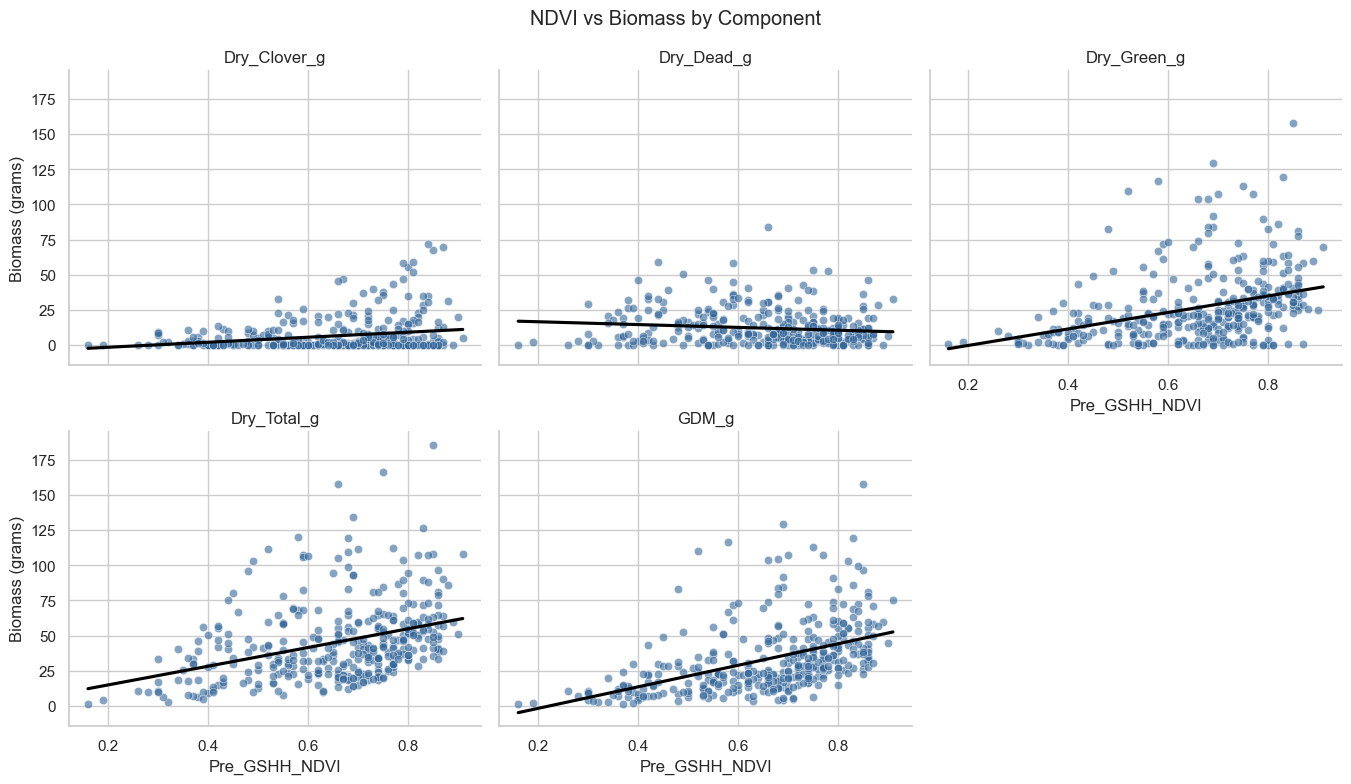

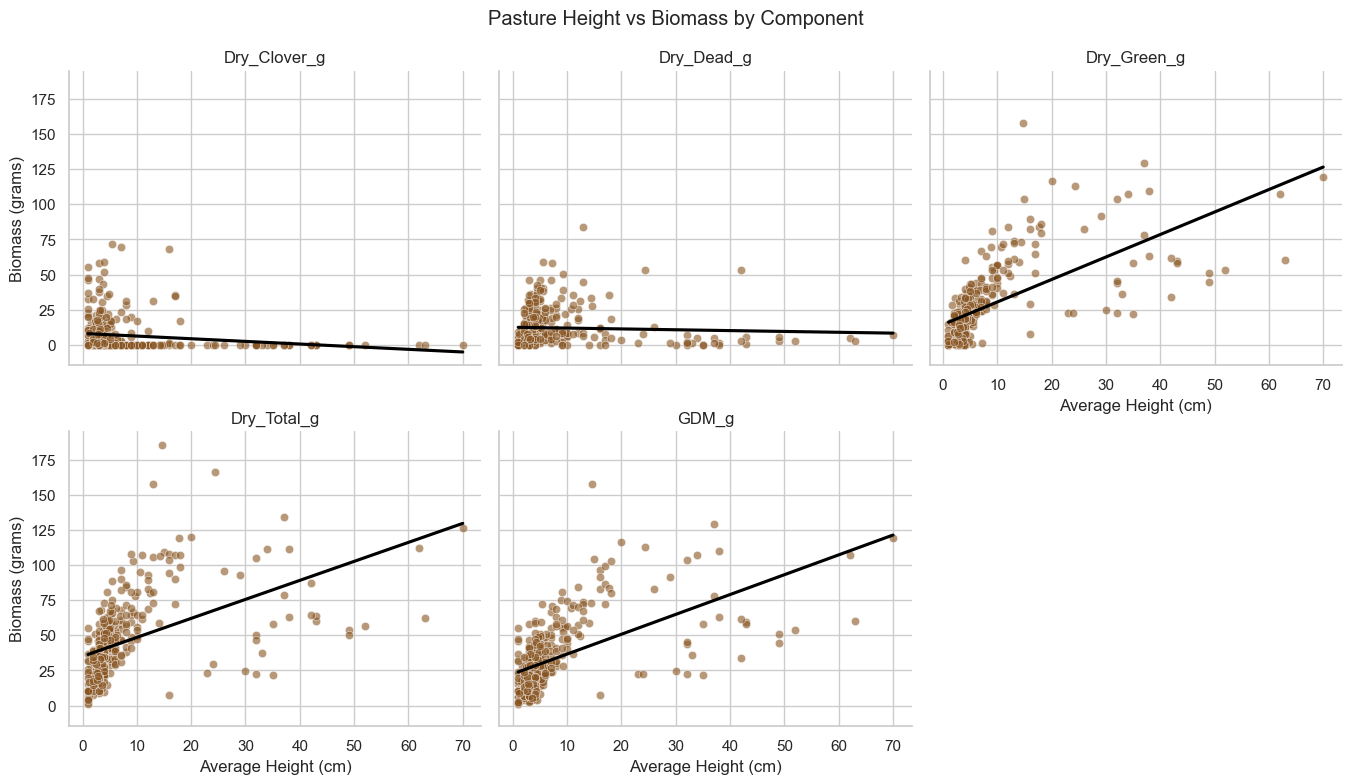

In [7]:
# ============================================================
# 01_EDA.ipynb — Block 6: Feature–target relations per component
# ============================================================

# --- Correlações por componente
corr_table = (
    train.groupby("target_name")
    .apply(lambda g: pd.Series({
        "corr_NDVI": g["Pre_GSHH_NDVI"].corr(g["target"]),
        "corr_Height": g["Height_Ave_cm"].corr(g["target"])
    }))
    .sort_index()
    .round(3)
)
display(corr_table)

# --- Pairwise plots: NDVI vs Biomass (facet)
g = sns.FacetGrid(train, col="target_name", col_wrap=3, height=3.8, aspect=1.2)
g.map_dataframe(
    sns.scatterplot,
    x="Pre_GSHH_NDVI",
    y="target",
    alpha=0.6,
    color="#336699"
)
g.map_dataframe(
    sns.regplot,
    x="Pre_GSHH_NDVI",
    y="target",
    scatter=False,
    ci=None,
    color="black"
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Pre_GSHH_NDVI", "Biomass (grams)")
g.fig.suptitle("NDVI vs Biomass by Component", y=1.03)
plt.show()

# --- Pairwise plots: Height vs Biomass (facet)
g = sns.FacetGrid(train, col="target_name", col_wrap=3, height=3.8, aspect=1.2)
g.map_dataframe(
    sns.scatterplot,
    x="Height_Ave_cm",
    y="target",
    alpha=0.6,
    color="#885522"
)
g.map_dataframe(
    sns.regplot,
    x="Height_Ave_cm",
    y="target",
    scatter=False,
    ci=None,
    color="black"
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Average Height (cm)", "Biomass (grams)")
g.fig.suptitle("Pasture Height vs Biomass by Component", y=1.03)
plt.show()

---

## Insights from NDVI and Height Relationships

### 1 NDVI vs Biomass
- **Positive but nonlinear correlation** between NDVI and the main biomass components (`Dry_Green_g`, `GDM_g`, and `Dry_Total_g`).  
  The relationship saturates at high NDVI values (> 0.8), which is consistent with real vegetation dynamics — NDVI becomes less sensitive when pastures are already dense and green.  
- **Weak or negative correlation** for `Dry_Dead_g` (as NDVI captures greenness rather than dead matter).  
- `Dry_Clover_g` shows weak dependence, possibly due to its low proportion and strong dependence on specific species composition.

**Modeling implications:**
- Expect **nonlinear responses**; linear models will underfit.  
- Consider including **polynomial or interaction terms** (e.g., NDVI², NDVI × Height) or letting neural networks learn these patterns directly.  
- NDVI remains a key predictor for the “green” components of biomass.

---

### 2 Height vs Biomass
- Stronger and more consistent correlation with **`Dry_Total_g`** and **`GDM_g`**, especially at low-to-medium height ranges (< 30 cm).  
- Relationship is again nonlinear: a near-flat region for short pastures, followed by a steep increase — suggesting a **threshold effect** for structural growth.  
- Little to no correlation for `Dry_Dead_g` and `Dry_Clover_g`.

**Modeling implications:**
- `Height_Ave_cm` is a valuable continuous feature, but it benefits from **log or quantile scaling**.  
- Combining Height and NDVI captures complementary aspects: **structure (height)** and **vigor (NDVI)**.

---

### 3 General observations
- The relationships are **heteroscedastic**: variance increases with biomass, indicating that predictive uncertainty should grow with larger values.  
- Cross-component differences justify a **multi-head regression model**, allowing each biomass component to learn its own mapping from shared features.  
- Feature engineering can focus on:
  - Normalized NDVI and Height
  - Seasonal sine–cosine encoding
  - Interactions like NDVI × Height or NDVI × Season

---

**Summary for modeling:**
The analysis confirms that NDVI and pasture height carry strong physical signals for total and green biomass, though their relationships are nonlinear and vary across components.  
Future models should handle nonlinearities explicitly (tree-based or neural) and account for inter-target dependencies through shared representations.


------------------------------
# Now, visual inspection of some nice images
------------------------------

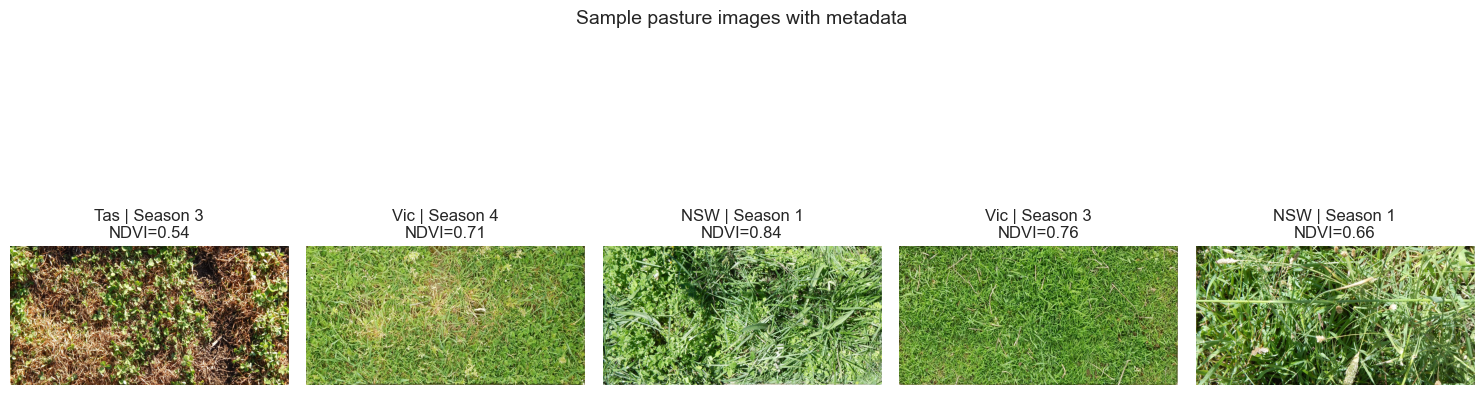

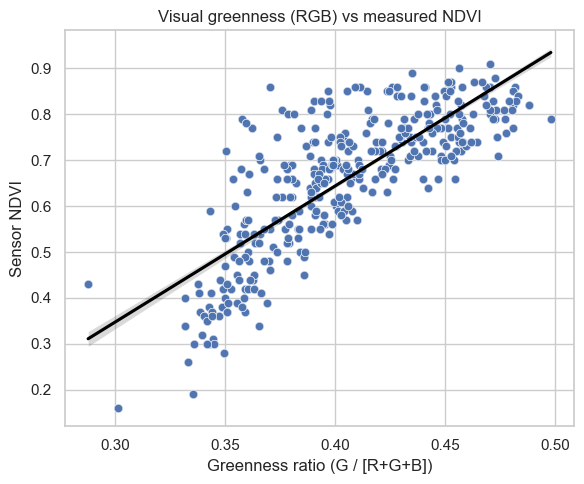

📈 Correlation between visual greenness and NDVI = 0.794


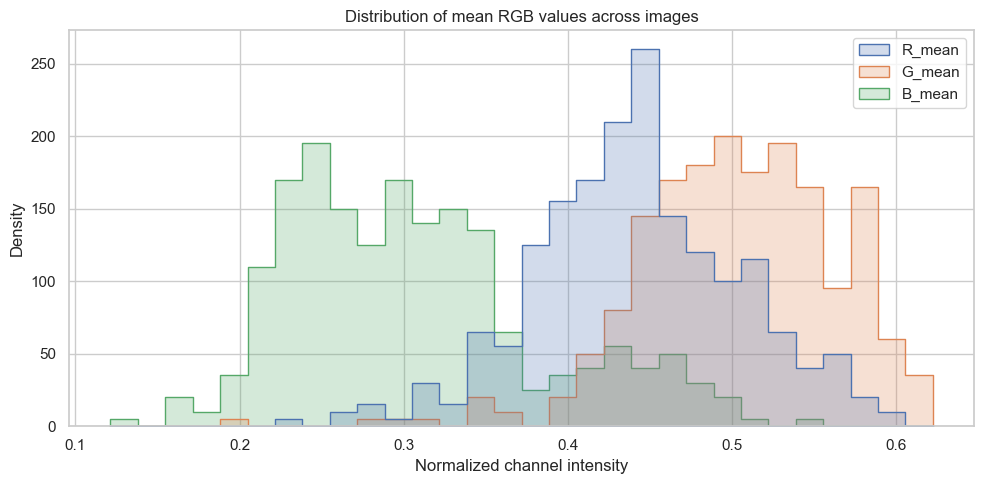

In [8]:
# ============================================================
# 01_EDA.ipynb — Block 7: Visual exploration of images
# ============================================================

import random
import numpy as np
from PIL import Image
from pathlib import Path

# ------------------------------------------------------------
# Helper: compute RGB stats and greenness proxy
# ------------------------------------------------------------
def image_color_stats(img_path):
    """Return mean RGB and greenness ratio from image."""
    img = np.array(Image.open(img_path).convert("RGB")) / 255.0
    mean_rgb = img.mean(axis=(0, 1))
    r, g, b = mean_rgb
    greenness = g / (r + g + b + 1e-6)
    brightness = (r + g + b) / 3.0
    return pd.Series({
        "R_mean": r,
        "G_mean": g,
        "B_mean": b,
        "Greenness": greenness,
        "Brightness": brightness
    })

# ------------------------------------------------------------
# Random sample of images to visualize
# ------------------------------------------------------------
SAMPLES = 5
sample_imgs = train["image_path"].sample(SAMPLES, random_state=42)

plt.figure(figsize=(15, 6))
for i, path_rel in enumerate(sample_imgs, 1):
    path_full = Path(BASE_DIR) / path_rel
    img = Image.open(path_full)
    plt.subplot(1, SAMPLES, i)
    plt.imshow(img)
    meta = train.loc[train["image_path"] == path_rel, ["State", "season", "Pre_GSHH_NDVI"]].iloc[0]
    plt.title(f"{meta.State} | Season {meta.season}\nNDVI={meta.Pre_GSHH_NDVI:.2f}")
    plt.axis("off")
plt.suptitle("Sample pasture images with metadata", fontsize=14)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Compute color stats for all training images
# ------------------------------------------------------------
img_stats = []
for path_rel in train["image_path"].unique():
    path_full = Path(BASE_DIR) / path_rel
    stats = image_color_stats(path_full)
    stats["image_path"] = path_rel
    img_stats.append(stats)

img_stats = pd.DataFrame(img_stats)
train_stats = train.merge(img_stats, on="image_path", how="left")

# ------------------------------------------------------------
# Compare visual greenness vs measured NDVI
# ------------------------------------------------------------
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=train_stats,
    x="Greenness",
    y="Pre_GSHH_NDVI",
    alpha=0.5
)
sns.regplot(
    data=train_stats,
    x="Greenness",
    y="Pre_GSHH_NDVI",
    scatter=False,
    color="black"
)
plt.title("Visual greenness (RGB) vs measured NDVI")
plt.xlabel("Greenness ratio (G / [R+G+B])")
plt.ylabel("Sensor NDVI")
plt.tight_layout()
plt.show()

corr_rgb_ndvi = train_stats["Greenness"].corr(train_stats["Pre_GSHH_NDVI"])
print(f"📈 Correlation between visual greenness and NDVI = {corr_rgb_ndvi:.3f}")

# ------------------------------------------------------------
# Color channel distributions
# ------------------------------------------------------------
plt.figure(figsize=(10,5))
sns.histplot(train_stats[["R_mean","G_mean","B_mean"]], bins=30, element="step", common_norm=False)
plt.title("Distribution of mean RGB values across images")
plt.xlabel("Normalized channel intensity")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


# 1 Strong but nonlinear relationship

- The relation is positive and monotonic; There is saturation for NDVI > 0.8 (when green dominates completely the RGB spectrum)
- NDVI looses sensibility in dense vegetation
- Linear models are not enough; but an image model (CNN or transformer) can learn this curve naturaly.


# 2. Visual channels carry meaningful signal

- Green channel is consistently more intense -> consistent with active vegetation.
- Dispersion and overlap between channels suggest that there are other natural variable playing a role and affecting colors(light, seasonality,...), so the model will need:

    - color normalization (ex: division by average brightness or standardize_per_image);
    - realistic data augmentation (jitter, contrast, hue).

# 3. Modeling implications

- Model may estimate NDVI implicitly -> nice for a test set that may have missing or inconsistent NVDI.
- Image-driven features (as “greenness proxy”, texture, or embeddings CNN) can be combined as tabular (Height_Ave_cm, State, Season) in a multimodal model.
- The strong correlation confirmms that visual data are predictive -> a good starting point for supervised learning

# 4. Conclusion for modeling stage

- The RGB channels encode a strong, nonlinear signature of vegetation vigor that parallels the NDVI readings.
- This validates the use of computer vision models (CNNs or Vision Transformers) as the main feature extractor.
- Color normalization and nonlinear modeling are essential to fully exploit this relationship.

Extracting embeddings: 100%|██████████████████████████████████████| 357/357 [00:31<00:00, 11.45it/s]


PCA explains 60.50% of variance in first 10 comps


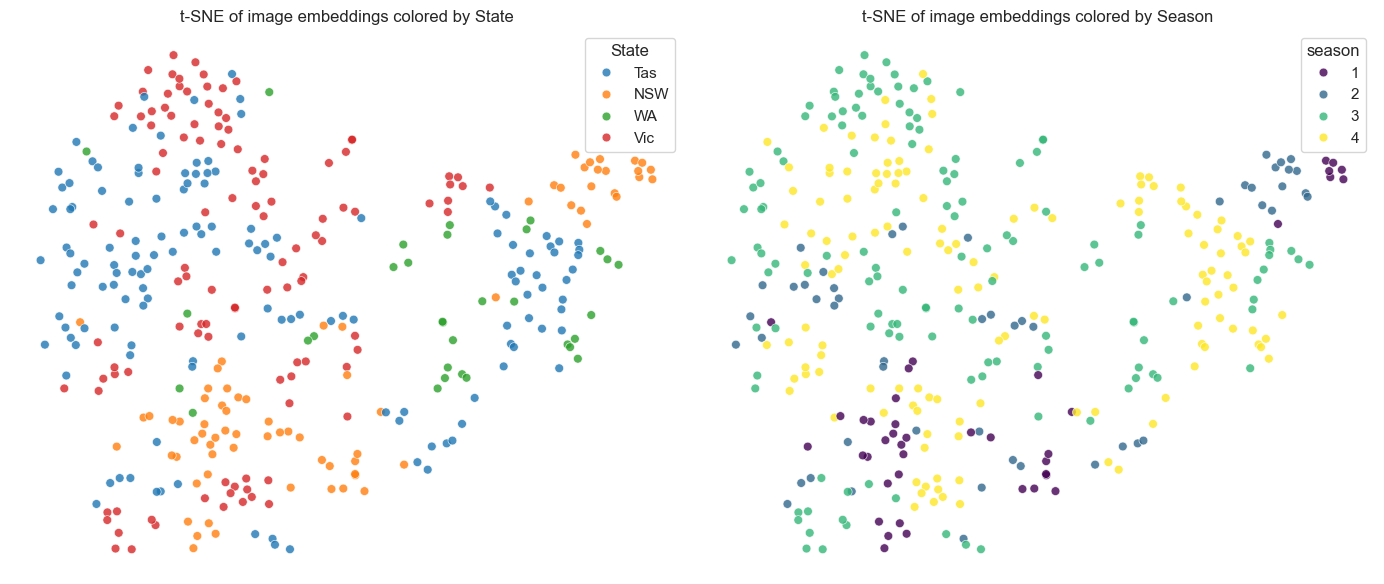

In [13]:
# ============================================================
# Image embeddings via EfficientNet
# ============================================================
import torch
import torchvision.transforms as T
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm

# ------------------------------------------------------------
# Load pretrained EfficientNet and set to feature-extraction mode
# ------------------------------------------------------------
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)
model.classifier = torch.nn.Identity()   # remove final classification layer
model.eval()

# Image preprocessing pipeline (version-safe)
if hasattr(weights, "transforms"):
    # torchvision >= 0.13 — recommended way
    transform = weights.transforms()
else:
    # fallback for older versions
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


# ------------------------------------------------------------
# Extract embeddings for a manageable subset (e.g., 300 imgs)
# ------------------------------------------------------------
N_SAMPLES = len(train)
img_paths = train["image_path"].unique()[:N_SAMPLES]
embeddings, meta = [], []

for path_rel in tqdm(img_paths, desc="Extracting embeddings"):
    path_full = Path(BASE_DIR) / path_rel
    img = Image.open(path_full).convert("RGB")
    x = transform(img).unsqueeze(0)
    with torch.no_grad():
        feat = model(x).squeeze().numpy()
    embeddings.append(feat)
    meta.append(train.loc[train["image_path"] == path_rel, ["State", "season"]].iloc[0])

embeddings = np.vstack(embeddings)
meta = pd.DataFrame(meta).reset_index(drop=True)

# ------------------------------------------------------------
# Dimensionality reduction (PCA + t-SNE)
# ------------------------------------------------------------
pca = PCA(n_components=50, random_state=42)
emb_pca = pca.fit_transform(embeddings)
print(f"PCA explains {pca.explained_variance_ratio_[:10].sum():.2%} of variance in first 10 comps")

tsne = TSNE(n_components=2, random_state=42, init="pca", perplexity=30)
emb_tsne = tsne.fit_transform(emb_pca)

meta["x"] = emb_tsne[:, 0]
meta["y"] = emb_tsne[:, 1]

# ------------------------------------------------------------
# Visualization: t-SNE colored by State and Season
# ------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=meta, x="x", y="y", hue="State", ax=ax[0], palette="tab10", s=40, alpha=0.8)
ax[0].set_title("t-SNE of image embeddings colored by State")
ax[0].axis("off")

sns.scatterplot(data=meta, x="x", y="y", hue="season", ax=ax[1], palette="viridis", s=40, alpha=0.8)
ax[1].set_title("t-SNE of image embeddings colored by Season")
ax[1].axis("off")

plt.tight_layout()
plt.show()


In [1]:
# save embeddings
import os
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import timm
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
# ============================
# CONFIG
# ============================
BASE_DIR = Path(".")
TRAIN_CSV = BASE_DIR / "train.csv"
TEST_CSV  = BASE_DIR / "test.csv"
IMG_DIR   = BASE_DIR   # ajuste para sua estrutura local

device = "cuda" if torch.cuda.is_available() else "cpu"

# ============================
# LOAD CSV
# ============================
train = pd.read_csv(TRAIN_CSV)
test  = pd.read_csv(TEST_CSV)

all_paths = (
    pd.concat([
        train[["image_path"]],
        test[["image_path"]]
    ])
    .drop_duplicates()
    .reset_index(drop=True)
)

print("Total images:", len(all_paths))

# ============================
# EfficientNet-B0
# ============================
model = timm.create_model("efficientnet_b0", pretrained=True)
model.classifier = nn.Identity()
model = model.to(device)
model.eval()

transform = timm.data.transforms_factory.create_transform(
    input_size=224,
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

# ============================
# EXTRACT EMBEDDINGS
# ============================
emb_list = []
id_list  = []

for img_path in tqdm(all_paths["image_path"], desc="Embedding"):
    im_full = Path(IMG_DIR) / img_path
    img = Image.open(im_full).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        feat = model(x).squeeze().cpu().numpy()

    emb_list.append(feat)
    id_list.append(img_path)
    #print(img_path, feat.shape)

emb_list = np.vstack(emb_list)
print("Raw embedding shape:", emb_list.shape)

emb_dim = emb_list.shape[1]

out_df = pd.DataFrame(
    emb_list,
    columns=[f"emb_{i}" for i in range(emb_dim)]
)

out_df["image_path"] = id_list
out_df["image_id"] = out_df["image_path"].str.extract(r"(ID\d+)")

out_df.to_csv("embeddings/image_embeddings.csv", index=False)
print("Saved → embeddings/image_embeddings.csv")

# ============================================================
# Save EfficientNet B0 locally for Kaggle inference
# ============================================================

import timm
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Loading ImageNet EfficientNet-B0...")
model_eff = timm.create_model("efficientnet_b0", pretrained=True)  # usa internet localmente
model_eff.classifier = nn.Identity()
model_eff = model_eff.to(device)

print("Saving model to efficientnet_b0_local.pth")
torch.save(model_eff.state_dict(), "embeddings/efficientnet_b0_local.pth")
print("Done!")


/home/mcvicentin/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Total images: 358


Embedding: 100%|██████████████████████████████████████████████████| 358/358 [00:43<00:00,  8.19it/s]


Raw embedding shape: (358, 1280)
Saved → embeddings/image_embeddings.csv
Loading ImageNet EfficientNet-B0...
Saving model to efficientnet_b0_local.pth
Done!


## 9. Summary and Outlook

The image embedding analysis confirms that visual features extracted from RGB pasture images
(using a pretrained EfficientNet) encode meaningful information about both **geographical** and
**seasonal** variability:

- PCA captured about **60% of the variance** within the first 10 components, suggesting a relatively
  compact latent representation of visual traits.
- t-SNE visualizations reveal grouping by **State** and **Season**, implying that the model is sensitive to regional and phenological differences in vegetation structure and color.
- This coherence between image embeddings and metadata reinforces the idea that **RGB-derived
  features** can complement sensor and field measurements (e.g., NDVI, biomass, pasture height)
  for predictive modeling.

Next steps are:
1. Integrate **image embeddings** with tabular predictors (NDVI, weather, soil, etc.) into a unified
   feature space.
2. Develop **regression and multimodal models** to predict biomass components.
3. Evaluate the contribution of image-based features to the overall model performance and
   generalization across sites and seasons.

---

✅ *Key insight:*  
Even without fine-tuning, pretrained CNNs already encode robust ecological information from simple
RGB imagery, making them powerful tools for data fusion in pasture biomass estimation.


-------
Since I forgot the 'Specie' column until now :o, I will include some analysis here to understand how I will incorporate it in the final model
-------
## 10. Species Analysis

In this final exploratory section, we investigate how pasture **Species** relate to the biomass components.  
Understanding this relation is important before building the multimodal model, since different species have distinct canopy architectures, dry matter accumulation patterns, and green/dead biomass proportions.

The analysis will go as follows:
- the distribution of images per species,
- the biomass distributions per species and target component,
- the mean biomass per species (heatmap),
- and a simple baseline model using only *Species* to estimate biomass.

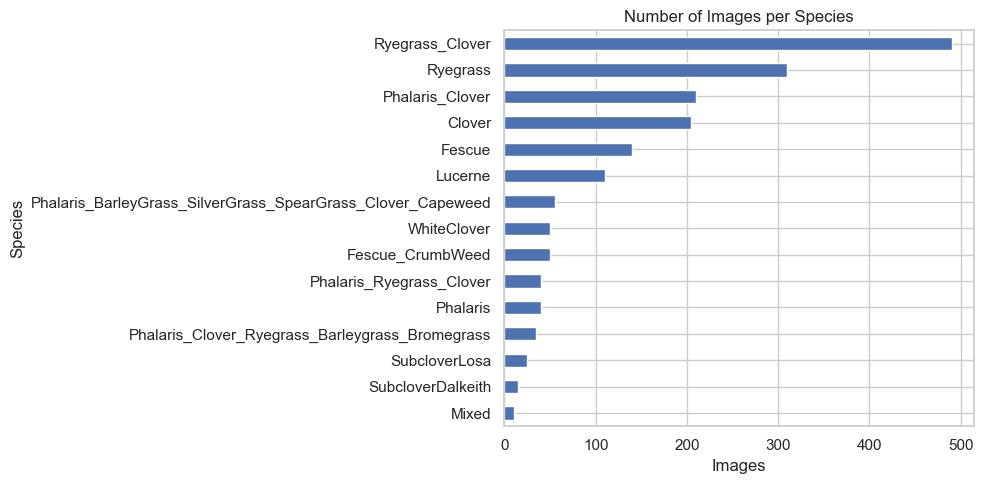

Species
Clover                                                         205
Fescue                                                         140
Fescue_CrumbWeed                                                50
Lucerne                                                        110
Mixed                                                           10
Phalaris                                                        40
Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed     55
Phalaris_Clover                                                210
Phalaris_Clover_Ryegrass_Barleygrass_Bromegrass                 35
Phalaris_Ryegrass_Clover                                        40
Ryegrass                                                       310
Ryegrass_Clover                                                490
SubcloverDalkeith                                               15
SubcloverLosa                                                   25
WhiteClover                                           

In [15]:
# ============================================================
# Species: number of images per species
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

species_counts = (
    train.groupby("Species")["sample_id"].nunique()
)

plt.figure(figsize=(10, 5))
species_counts.sort_values().plot(kind="barh")
plt.title("Number of Images per Species")
plt.xlabel("Images")
plt.tight_layout()
plt.show()

species_counts

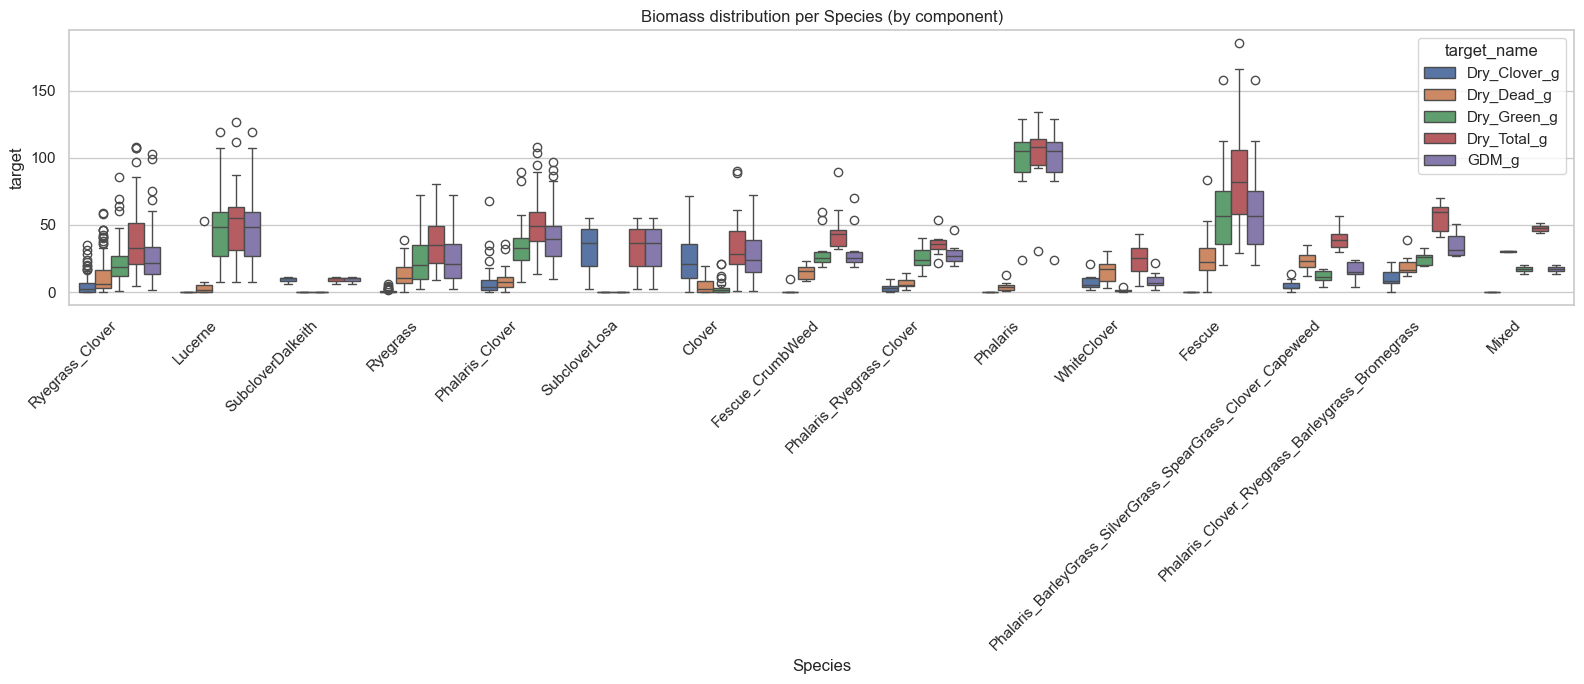

In [16]:
# ============================================================
# Biomass distribution by Species and Target
# ============================================================

plt.figure(figsize=(16, 7))
sns.boxplot(
    data=train,
    x="Species",
    y="target",
    hue="target_name"
)
plt.xticks(rotation=45, ha="right")
plt.title("Biomass distribution per Species (by component)")
plt.tight_layout()
plt.show()

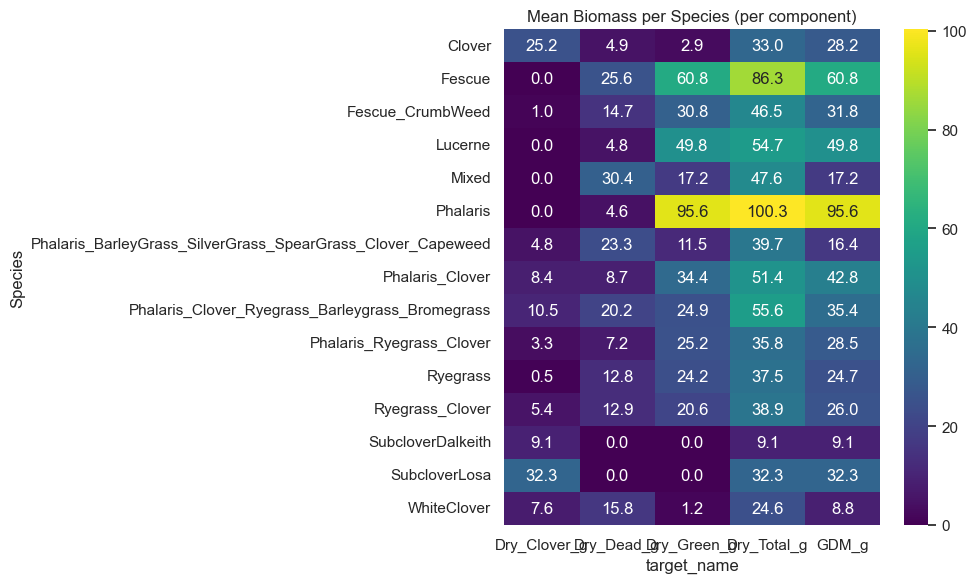

target_name,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
Species,,,,,
Clover,25.241576,4.871910,2.922588,33.036083,28.164161
Fescue,0.000000,25.556457,60.761400,86.317857,60.761400
Fescue_CrumbWeed,1.009810,14.741220,30.798970,46.550000,31.808780
Lucerne,0.000000,4.806259,49.848286,54.654545,49.848286
Mixed,0.000000,30.381700,17.181300,47.563000,17.181300
Phalaris,0.000000,4.615412,95.647087,100.262500,95.647087
Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed,4.842545,23.297309,11.523773,39.663636,16.366327
Phalaris_Clover,8.407379,8.651636,34.350276,51.409286,42.757650
Phalaris_Clover_Ryegrass_Barleygrass_Bromegrass,10.532314,20.163200,24.861600,55.557143,35.393943


In [17]:
# ============================================================
# Mean biomass per Species and component (heatmap)
# ============================================================

species_stats = (
    train.groupby(["Species", "target_name"])["target"]
         .mean()
         .unstack()
)

plt.figure(figsize=(10, 6))
sns.heatmap(species_stats, annot=True, fmt=".1f", cmap="viridis")
plt.title("Mean Biomass per Species (per component)")
plt.tight_layout()
plt.show()

species_stats

In [18]:
# ============================================================
# Predicting biomass using only Species → how informative is it?
# ============================================================

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import GroupShuffleSplit

# Same group-aware logic: avoid mixing lines from the same image
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(train, groups=train["image_id"]))

X_train = train.iloc[train_idx][["Species"]]
y_train = train.iloc[train_idx]["target"]

X_val   = train.iloc[val_idx][["Species"]]
y_val   = train.iloc[val_idx]["target"]

pipe = Pipeline([
    ("enc", OneHotEncoder(handle_unknown="ignore")),
    ("ridge", Ridge(alpha=1.0))
])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_val)

print("R² using only Species:", r2_score(y_val, pred))

R² using only Species: 0.037214242711386625


## 10. Analysis of Species Effects on Biomass: summary

The dataset contains 15 distinct vegetation species, with a highly imbalanced distribution (e.g., *Ryegrass_Clover* with ~490 samples vs. *Mixed* with only 10). This imbalance must be carefully handled in downstream modeling.

### Key findings

**1. Strong species-level differences in biomass**

Boxplots and heatmaps show clear group-level patterns:
- Species such as **Phalaris** and its combinations tend to exhibit very high biomass.
- Species like **Subclover**, **SubcloverDalkeith**, and some mixed grasses show very low biomass.
- Intermediate categories (e.g., *Ryegrass*, *Clover*, *Lucerne*) span a wide range of target values.

This indicates that *Species* contains meaningful biological information related to plant productivity.

---

**2. Species alone is not predictive**

A simple model trained using only the *Species* column (via encoding) achieves:

- **R² ≈ 0.03**

Despite strong visual differences between species, this variable alone explains only a small fraction of the variability in biomass. Biomass is strongly dependent on environmental and sensor-derived features (NDVI, height, season, etc.), and species acts more as a *modifier* rather than a dominant driver.

---

**3. Implications for the multimodal model**

Given:
- The strong biological differences between species,
- The imbalance across categories,
- And the weak performance when used in isolation,

we conclude that **Species should be included as an auxiliary feature**, but with careful encoding:

- For tree-based models (LightGBM, CatBoost):  
  - Prefer **native categorical handling** (CatBoost) or **target/leave-one-out encoding** (LightGBM).
- For neural-network multimodal models:  
  - Use a **learned embedding** (`nn.Embedding(num_species, embedding_dim)`), typically with 4–8 dimensions.
- Avoid simple one-hot encoding, as it increases dimensionality and amplifies class imbalance.

---

**Conclusion**

Species contributes meaningful structural information but is insufficient as a standalone predictor. It should be combined with environmental metadata, sensor-derived features, and image embeddings in the multimodal model developed in Notebook 03.
